In [34]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.api as sm
import statsmodels.formula.api as smf
plt.style.use('seaborn-whitegrid')
from sklearn import datasets
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

In [35]:
# magic to reload modules automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
#!pip install stargazer
#conda install -c conda-forge statsmodels

In [37]:
rt = pd.read_excel('rt.xlsx')
msci = pd.read_excel('data/KP.xlsx', skiprows=2)
esg_esg = pd.read_excel('esg_esg.xlsx')
it = pd.read_excel('it.xlsx')
ff = pd.read_excel('ff.xlsx')
esg_esg.rename(columns={'Unnamed: 0':'scores'}, inplace=True)
rt = rt.replace(0, np.nan)
rt.dropna(how='all', axis='index', thresh=4, inplace=True)
rt = rt.replace(np.nan, 0)

In [38]:
pd.set_option('display.max_columns',125) # I want to see all the columns
pd.set_option('display.max_rows',600) 

In [39]:
it = it.loc[:,['Unnamed: 0.1','DAX Index','OMXS30B Index','OMXC25 Index','OMX Index']]

for i in it.columns[1:]:
    it.loc[:,i] = it.loc[:,i].pct_change(1)*100
it.drop(index=[0], inplace=True)
it.rename(columns={'Unnamed: 0.1' : 'date'}, inplace=True)
rt.drop(columns='Unnamed: 0', inplace=True)
ff.drop(columns='Unnamed: 0', inplace=True)
rt = rt.loc[:,['date','port_low','port_mid','port_high']]

In [40]:
msci.drop(index=[0,1,2], inplace=True)
msci.rename(columns = {'Unnamed: 0' : 'date','Unnamed: 1' : 'MSCI_World', 'Unnamed: 2' : 'SPX', 'Unnamed: 3' : 'MSCI_Eur'}, inplace=True)
msci['date'] = pd.to_datetime(msci['date'], format='%Y%m%d')
for i in msci.columns[1:]:
    msci.loc[:,i] = msci.loc[:,i].pct_change(1)*100
msci.reset_index(inplace = True, drop = True)
msci.drop(index=[0], inplace=True)

In [41]:
rt = rt.merge(ff,on=['date'], how='left')
rt = rt.merge(it,on=['date'], how='left')
rt = rt.merge(msci,on=['date'], how='left')
pd.set_option("display.precision", 3)
#rt['RF'] = rt['RF']*100
rt.rename(columns = {'DAX Index' : 'DAX','OMXS30B Index' : 'S30','OMXC25 Index' : 'C25',
                     'OMX Index' : 'OMX','Mkt-RF' : 'MktRF'}, inplace=True)

In [42]:
filt = (rt['date'] >= pd.to_datetime('2013-01-01')) & (rt['date'] <= pd.to_datetime('2022-02-28')) 
#filt = (rt['date'] >= pd.to_datetime('2013-01-01')) & (rt['date'] <= pd.to_datetime('2019-12-31')) #new period 1
#filt = (rt['date'] >= pd.to_datetime('2020-01-01')) & (rt['date'] <= pd.to_datetime('2022-02-28')) #new period 2
rt = rt[filt]
rt.dropna(how='all', axis='index', thresh=5, inplace=True)

In [43]:
rt['MSCI_World'] = rt['MSCI_World'] - rt['RF']

In [44]:
filt = rt[['port_low','port_mid','port_high']].describe()
filt
#print(filt.to_latex(index = True, multirow = True))

,port_low,port_mid,port_high
count,2273.000,2273.000,2273.000
mean,0.074,0.041,0.047
std,1.043,1.035,1.084
min,-10.321,-10.736,-11.413
25%,-0.401,-0.434,-0.437
50%,0.123,0.081,0.081
75%,0.598,0.575,0.595
max,7.275,6.682,8.876


In [45]:
ame = ['SPX','MSCI_Eur']
rt.drop(columns=ame, inplace = True)
filt2 = rt.describe()
#print(filt2.to_latex(index = True, multirow = True))

In [46]:
model1 = smf.ols(formula='port_low ~ MktRF', data=rt).fit() 
model11 = smf.ols(formula='port_low ~ MktRF + SMB + HML', data=rt).fit() 
model111 = smf.ols(formula='port_low ~ MktRF + SMB + HML + RMW + CMA', data=rt).fit() 

In [47]:
model2 = smf.ols(formula='port_mid ~ MktRF', data=rt).fit() 
model22 = smf.ols(formula='port_mid ~ MktRF + SMB + HML', data=rt).fit() 
model222 = smf.ols(formula='port_mid ~ MktRF + SMB + HML + RMW + CMA', data=rt).fit() 

In [48]:
model3 = smf.ols(formula='port_high ~ MktRF', data=rt).fit() 
model33 = smf.ols(formula='port_high ~ MktRF + SMB + HML', data=rt).fit() 
model333 = smf.ols(formula='port_high ~ MktRF + SMB + HML + RMW + CMA', data=rt).fit() 
#print(model3.summary())
#trend = model3.params[0] + model3.params[1]* rt['port_high']
#plt.scatter(rt['port_high'],rt['MktRF'])
#plt.plot(trend, rt['port_high'], 'r');

In [49]:
stargazer = Stargazer([model1, model2, model3, model11, model22, model22, model111, model222, model333])
stargazer.custom_columns(['CAMP low', 'CAMP mid', 'CAMP high', 'FF3 low', 'FF3 mid', 'FF3 high', 'FF5 low', 'FF5 mid', 'FF5 high'], [1, 1, 1, 1, 1, 1, 1, 1, 1])
stargazer.show_model_numbers(False)
stargazer.covariate_order(['Intercept', 'MktRF', 'SMB', 'HML', 'RMW', 'CMA'])
stargazer.show_degrees_of_freedom(False)
stargazer.rename_covariates({'Intercept': 'alpha','MktRF' : 'beta_1','SMB' : 'beta_2 (SMB)', 'HML' : 'beta_3 (HML)',
                          'RMW' : 'beta_4 (RMW)', 'CMA' : 'beta_5 (CMA)'}) #if you want to change names
#HTML(stargazer.render_html())
# Use this guide to addit the table
#print(stargazer.render_latex()) #compile it in LaTeX instead of HTML

In [50]:
def SR(m):
    SR = (m.mean()/m.std())*252**.5
    return SR
sharpe_ratio = []
for i in filt.columns[:3]:
    sharpe_ratio.append(SR(rt[i]))

In [51]:
betas = [model1.params[1], model2.params[1], model3.params[1]]
def TR(m):
    for j in betas:
        TR = (m.mean()/ j )*252**.5
    return TR
treynor_ratio = []
for i in filt.columns[:3]:
    treynor_ratio.append(TR(rt[i]))

In [52]:
betas

[0.8298780419045775, 0.8572497935452652, 0.9084793401547666]

In [53]:
sharpe_ratio

[1.1283169443653005, 0.6281863286451744, 0.6875758043722663]

In [54]:
treynor_ratio

[1.2951104587627216, 0.7155739352306569, 0.8206226427426998]

In [55]:
model1 = smf.ols(formula='port_low ~ MSCI_World', data=rt).fit() 
model11 = smf.ols(formula='port_low ~ MSCI_World + SMB + HML', data=rt).fit() 
model111 = smf.ols(formula='port_low ~ MSCI_World + SMB + HML + RMW + CMA', data=rt).fit() 

model2 = smf.ols(formula='port_mid ~ MSCI_World', data=rt).fit() 
model22 = smf.ols(formula='port_mid ~ MSCI_World + SMB + HML', data=rt).fit() 
model222 = smf.ols(formula='port_mid ~ MSCI_World + SMB + HML + RMW + CMA', data=rt).fit() 

model3 = smf.ols(formula='port_high ~ MSCI_World', data=rt).fit() 
model33 = smf.ols(formula='port_high ~ MSCI_World + SMB + HML', data=rt).fit() 
model333 = smf.ols(formula='port_high ~ MSCI_World + SMB + HML + RMW + CMA', data=rt).fit() 
#print(model3.summary())
#trend = model3.params[0] + model3.params[1]* rt['port_high']
#plt.scatter(rt['port_high'],rt['MktRF'])
#plt.plot(trend, rt['port_high'], 'r');

stargazer = Stargazer([model1, model2, model3, model11, model22, model22, model111, model222, model333])
stargazer.custom_columns(['CAMP low', 'CAMP mid', 'CAMP high', 'FF3 low', 'FF3 mid', 'FF3 high', 'FF5 low', 'FF5 mid', 'FF5 high'], [1, 1, 1, 1, 1, 1, 1, 1, 1])
stargazer.show_model_numbers(False)
stargazer.covariate_order(['Intercept', 'MSCI_World', 'SMB', 'HML', 'RMW', 'CMA'])
stargazer.show_degrees_of_freedom(False)
stargazer.rename_covariates({'Intercept': 'alpha','MSCI_World' : 'beta_1','SMB' : 'beta_2 (SMB)', 'HML' : 'beta_3 (HML)',
                          'RMW' : 'beta_4 (RMW)', 'CMA' : 'beta_5 (CMA)'}) #if you want to change names
#HTML(stargazer.render_html())
# Use this guide to addit the table
#print(stargazer.render_latex()) #compile it in LaTeX instead of HTML

In [56]:
filt3 = rt[['port_low','port_mid','port_high']]
col = filt3.columns.tolist()
mean_list = (rt[['port_low','port_mid','port_high']].mean() * 252).tolist()
sd_list = (rt[['port_low','port_mid','port_high']].std() * 252**0.5).tolist()

In [57]:
stra = zip(mean_list, sd_list, sharpe_ratio, treynor_ratio)
res = dict(zip(col, stra))
res = pd.DataFrame(res, index = ['Mean','SD','SR','TR'])
pd.set_option("display.precision", 2)

In [58]:
res

,port_low,port_mid,port_high
Mean,18.68,10.32,11.83
SD,16.55,16.43,17.21
SR,1.13,0.63,0.69
TR,1.30,0.72,0.82


In [59]:
#print(res.to_latex(index = True, multirow = True))

In [60]:
rt

,date,port_low,port_mid,port_high,MktRF,SMB,HML,RMW,CMA,RF,DAX,S30,C25,OMX,MSCI_World
0,2013-04-03,-0.05,-0.58,-0.32,-0.60,0.38,-0.54,0.37,-0.20,0.0,-0.87,-0.55,0.17,-0.55,-0.68
1,2013-04-04,-1.06,-1.53,-0.70,-0.32,0.30,0.61,-0.28,0.39,0.0,-0.73,-1.69,-1.48,-1.69,-0.24
2,2013-04-05,-1.74,-1.56,-2.01,-0.84,0.15,0.33,-0.14,0.19,0.0,-2.03,-1.20,-1.52,-1.20,-0.22
3,2013-04-08,0.43,0.47,0.35,0.15,-0.31,-0.56,0.43,-0.23,0.0,0.05,-0.34,0.60,-0.34,0.52
4,2013-04-09,0.08,0.20,0.53,0.78,0.19,0.94,-0.47,0.34,0.0,-0.33,0.92,0.02,0.92,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,2022-02-22,0.37,-0.06,-0.13,0.54,-0.11,-0.31,0.32,-0.27,0.0,-0.26,-0.06,0.12,-0.06,-0.88
2269,2022-02-23,-0.25,-0.61,-0.13,-0.58,0.09,-0.02,0.31,0.16,0.0,-0.42,-0.74,-0.60,-0.74,-1.37
2270,2022-02-24,-2.49,-3.45,-1.85,-3.57,0.45,-1.82,1.00,-0.40,0.0,-3.96,-2.99,0.36,-2.99,-0.12
2271,2022-02-25,2.80,2.58,3.08,3.66,-0.63,-0.19,-0.14,-0.17,0.0,3.67,3.05,3.37,3.05,2.56


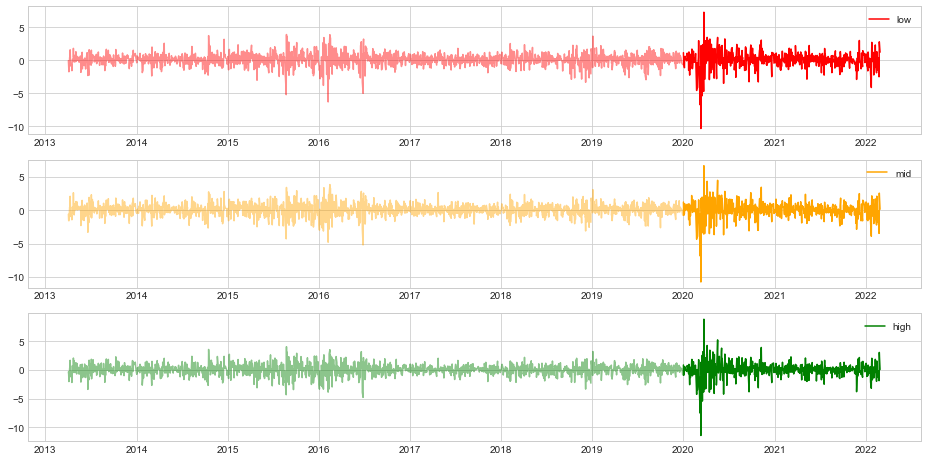

In [76]:
filt1 = (rt['date'] >= pd.to_datetime('2013-01-01')) & (rt['date'] <= pd.to_datetime('2019-12-31')) #new period 1
filt2 = (rt['date'] >= pd.to_datetime('2020-01-01')) & (rt['date'] <= pd.to_datetime('2022-02-28')) #new period 2

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(3,1,1)
ax1.plot(rt[filt1].date, rt[filt1].port_low, color='r', alpha=0.45)
ax1.plot(rt[filt2].date, rt[filt2].port_low, color='r', label='low')
ax1.legend()
ax2 = fig.add_subplot(3,1,2)
ax2.plot(rt[filt1].date, rt[filt1].port_mid, color='orange', alpha=0.45)
ax2.plot(rt[filt2].date, rt[filt2].port_mid, color='orange', label='mid')
ax2.legend()
ax3 = fig.add_subplot(3,1,3)
ax3.plot(rt[filt1].date, rt[filt1].port_high, color='g', alpha=0.45)
ax3.plot(rt[filt2].date, rt[filt2].port_high, color='g', label='high')
ax3.legend()
plt.savefig('vol.png');